<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/12_combining_features_with_zscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining Features



Our baseline approach for combining features in the cross-section is using their rank.

But there are other approaches, such as the cross-sectional z-score.

The usual cross-sectional zscore is to take the observation and subtract the mean of all observations that day and divide by the standard deviation of all observations that day.

But if you take the observation and subtract the mean of the observations for that day and divide by the sd of all observations for all tickers over the last month (say) it's going to be way more stable - we hope that this might lead to less turnover without being a drag on performance.

Let's test this out.

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "glue", "tibbletime","roll","RcppRoll","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




vctrs (0.6.4 -> 0.6.5) [CRAN]
bit   (4.0.4 -> 4.0.5) [CRAN]
cpp11 (0.4.6 -> 0.4.7) [CRAN]


Installing 3 packages: vctrs, bit, cpp11

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



fansi    (1.0.5    -> 1.0.6   ) [CRAN]
processx (3.8.2    -> 3.8.3   ) [CRAN]
pkgbuild (1.4.2    -> 1.4.3   ) [CRAN]
desc     (1.4.2    -> 1.4.3   ) [CRAN]
progress (1.2.2    -> 1.2.3   ) [CRAN]
openssl  (2.0.6    -> 2.1.1   ) [CRAN]
jsonlite (1.8.7    -> 1.8.8   ) [CRAN]
curl     (5.0.2    -> 5.2.0   ) [CRAN]
gargle   (1.5.1    -> 1.5.2   ) [CRAN]
brio     (1.1.3    -> 1.1.4   ) [CRAN]
vroom    (1.6.4    -> 1.6.5   ) [CRAN]
testthat (3.2.0    -> 3.2.1   ) [CRAN]
arrow    (13.0.0.1 -> 14.0.0.2) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpfpmIFu/remotes1563f39b249/RWLab-rwRtools-9f16cfc/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.66.tar.gz’

highr       (0.9   -> 0.10 ) [CRAN]
sass        (0

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Get data and make universe

In [3]:
# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

# load binance prices
prices <- rwRtools::crypto_get_binance_spot_1h()

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 830.3 Mb )





File successfully transferred


In [4]:
#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

   # remove from market_cap data anything that wasn't trading on Binance or is a stable/duplicate
  binance_tickers <- pull(prices, Ticker)
  market_cap <- market_cap %>%
    filter(!Ticker %in% c(stables, to_remove)) %>%
    filter(Ticker %in% binance_tickers)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    # where remaining tickers are missing market cap data, fill forward
    group_by(Ticker) %>%
    arrange(Date) %>%
    fill(MarketCapUSD, .direction = "down") %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 8)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=10, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4360.69,72153449099,1,FALSE
2017-08-17,ETH,308.62,28752742413,2,FALSE
2017-08-18,BTC,4282.73,70206129858,1,FALSE
2017-08-18,ETH,304.23,28406320026,2,FALSE
2017-08-19,BTC,3999.00,67500579074,1,FALSE
2017-08-19,ETH,288.40,27839631816,2,FALSE


## Make cross-sectional features

In [5]:
library(Rcpp)
cppFunction(
  code = 'NumericVector ema(NumericVector vec, int window) {
    double smoothing_factor = 2.0;
    double alpha = smoothing_factor/(window + 1);
    double beta = 1.0 - alpha;

    NumericVector ema = {vec[0]};
    if (vec.size() > 0 ) {
      for (int i = 1; i != vec.size(); ++i) { // Start iterating from  + 1 because I need the last value
          ema.push_back((vec[i] * alpha) + (ema[i-1] * beta));

        }
      return ema;
    }
}'
)

Baseline way of weighting features:

In [6]:
rolling_days_since_high_10 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 10, na_value = NA),
  otherwise = NA
)

mom_factor_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Close momo factor
  mutate(
    x_mom_9 = log(Close / lag(Close, n = 9)),
    x_mom_13 = log(Close / lag(Close, n = 13)),
    x_mom_22 = log(Close / lag(Close, n = 22)),
  ) %>%
  # Close to SMA factor
  mutate(
    x_psma_11 = Close / roll_meanr(Close, 11) - 1,
    x_psma_19 = Close / roll_meanr(Close, 19) - 1,
    x_psma_33 = Close / roll_meanr(Close, 33) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    x_smaf_3_17 = roll_meanr(Close, 3) / roll_meanr(Close, 17) - 1,
    x_smaf_5_28 = roll_meanr(Close, 5) / roll_meanr(Close, 28) - 1,
  ) %>%
  # Range over recent history
  mutate(
    x_rrp_11 = (Close - roll_meanr(Close, n = 11)) / roll_sdr(Close, n = 11),
    x_rrp_18 = (Close - roll_meanr(Close, n = 18)) / roll_sdr(Close, n = 18),
    x_rrp_33 = (Close - roll_meanr(Close, n = 33)) / roll_sdr(Close, n = 33),
    x_rrp_41 = (Close - roll_meanr(Close, n = 41)) / roll_sdr(Close, n = 41),
  ) %>%
  # Range
  mutate(
    x_range_12 = (Close - roll_minr(Close, n = 12)) / (roll_maxr(Close, n = 12) - roll_minr(Close, n = 12)),
    x_range_20 = (Close - roll_minr(Close, n = 20)) / (roll_maxr(Close, n = 20) - roll_minr(Close, n = 20)),
    x_range_29 = (Close - roll_minr(Close, n = 29)) / (roll_maxr(Close, n = 29) - roll_minr(Close, n = 29)),
  ) %>%
  # Days since last high factor
  mutate(
    x_dsh_10 = -rolling_days_since_high_10(Close)
  ) %>%
  # Calculate returns
  mutate(
    fwd_return_1 = lead(Close,1) / Close - 1,
    fwd_return_2 = lead(Close,2) / lead(Close, 1) - 1,
    fwd_return_3 = lead(Close,3) / lead(Close, 2) - 1,
    fwd_log_return_1 = log(lead(Close) / Close),
    fwd_log_return_2 = log(lead(Close,2) / lead(Close, 1)),
    fwd_log_return_3 = log(lead(Close,3) / lead(Close, 2))
  ) %>%
  na.omit() %>%
  ungroup()

mom_ranks <- mom_factor_wide %>%
  pivot_longer(starts_with('x_'), names_to = 'feature', values_to = 'value') %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  mutate(
    # rank = row_number(value),  # previous approach
    rank = min_rank(value),
    weight = rank - mean(rank),
    # scaled_weight = weight/sum(abs(weight)),
    scaled_weight = case_when(
      sum(abs(weight)) == 0 ~ 0,  # happens when all the weights are zero, f.i. when the x_dsh factors are all past their lookback period and all get the same rank
      TRUE ~ weight/sum(abs(weight))
    ),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

mom_factor <- mom_ranks %>%
  group_by(Date, feature) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


Zscore with a longer standard deviation over all tickers:

In [7]:
sd_lookback <- 30

mom_ranks_scaled_zs <- mom_factor_wide %>%
  pivot_longer(starts_with('x_'), names_to = 'feature', values_to = 'value') %>%
  filter(is_index) %>%
  # calculate rolling standard deviation by feature (all tickers)
  group_by(feature) %>%
  mutate(
    feature_sd = RcppRoll::roll_sd(value, n = sd_lookback, align = "right", fill = NA)
  ) %>%
  group_by(Date, feature) %>%
  mutate(
    feature_zs = (value - mean(value))/feature_sd,
    scaled_weight = feature_zs/sum(abs(feature_zs)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

mom_factor_scaled_zs <- mom_ranks_scaled_zs %>%
  group_by(Date, feature) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


Compare weights for a couple of tickers using both approaches:

Adding missing grouping variables: `feature`
Adding missing grouping variables: `feature`


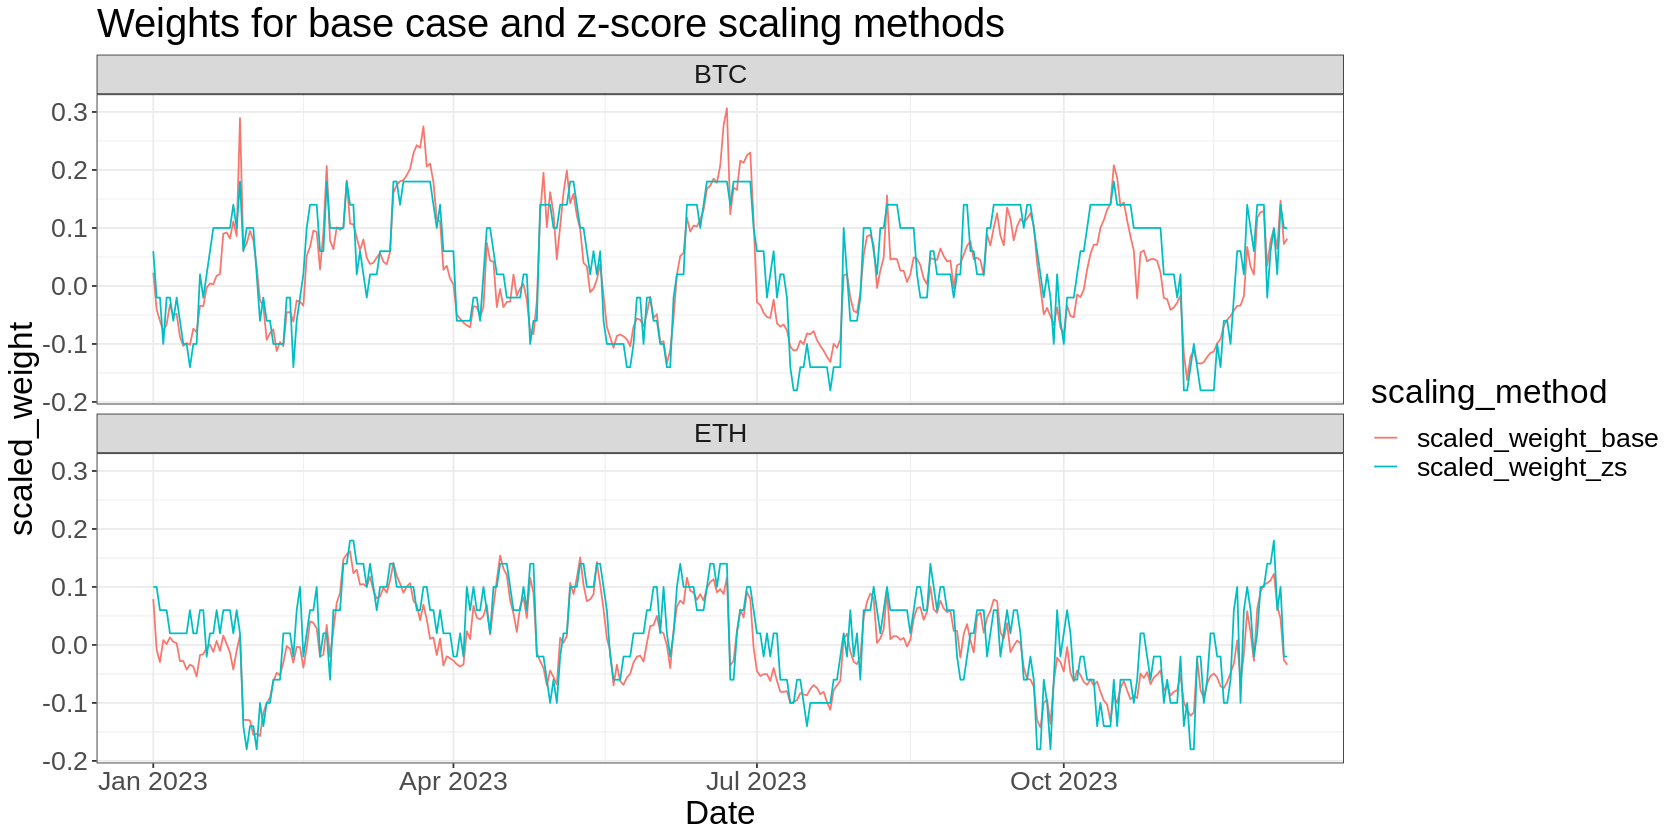

In [8]:
mom_ranks_scaled_zs %>%
  filter(feature == 'x_mom_13', Ticker %in% c('BTC', 'ETH'), Date >= "2023-01-01") %>%
  select(Date, Ticker, scaled_weight) %>%
  left_join(
    mom_ranks %>% filter(feature == 'x_mom_13', Ticker %in% c('BTC', 'ETH')) %>% select(Date, Ticker, scaled_weight),
    by = c('Ticker', 'Date'),
    suffix = c('_base', '_zs')
  ) %>%
  pivot_longer(c(scaled_weight_base, scaled_weight_zs), names_to = "scaling_method", values_to = "scaled_weight") %>%
  ggplot(aes(x = Date, y = scaled_weight, colour = scaling_method)) +
  geom_line() +
  facet_wrap(~Ticker, ncol = 1) +
  labs(
    title = "Weights for base case and z-score scaling methods"
  )

The new method results in much more stable weights.

Let's see if it's a drag on frictionless performance:

In [9]:
megafactor_base <- mom_ranks %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(rank))

megafactor_cumreturns_base <- megafactor_base %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
  ) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
  )

megafactor_scaled_zs <- mom_ranks_scaled_zs %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(scaled_weight))

megafactor_cumreturns_scaled_zs <- megafactor_scaled_zs %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
  ) %>%
  arrange(Date) %>%
  na.omit() %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
  )

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


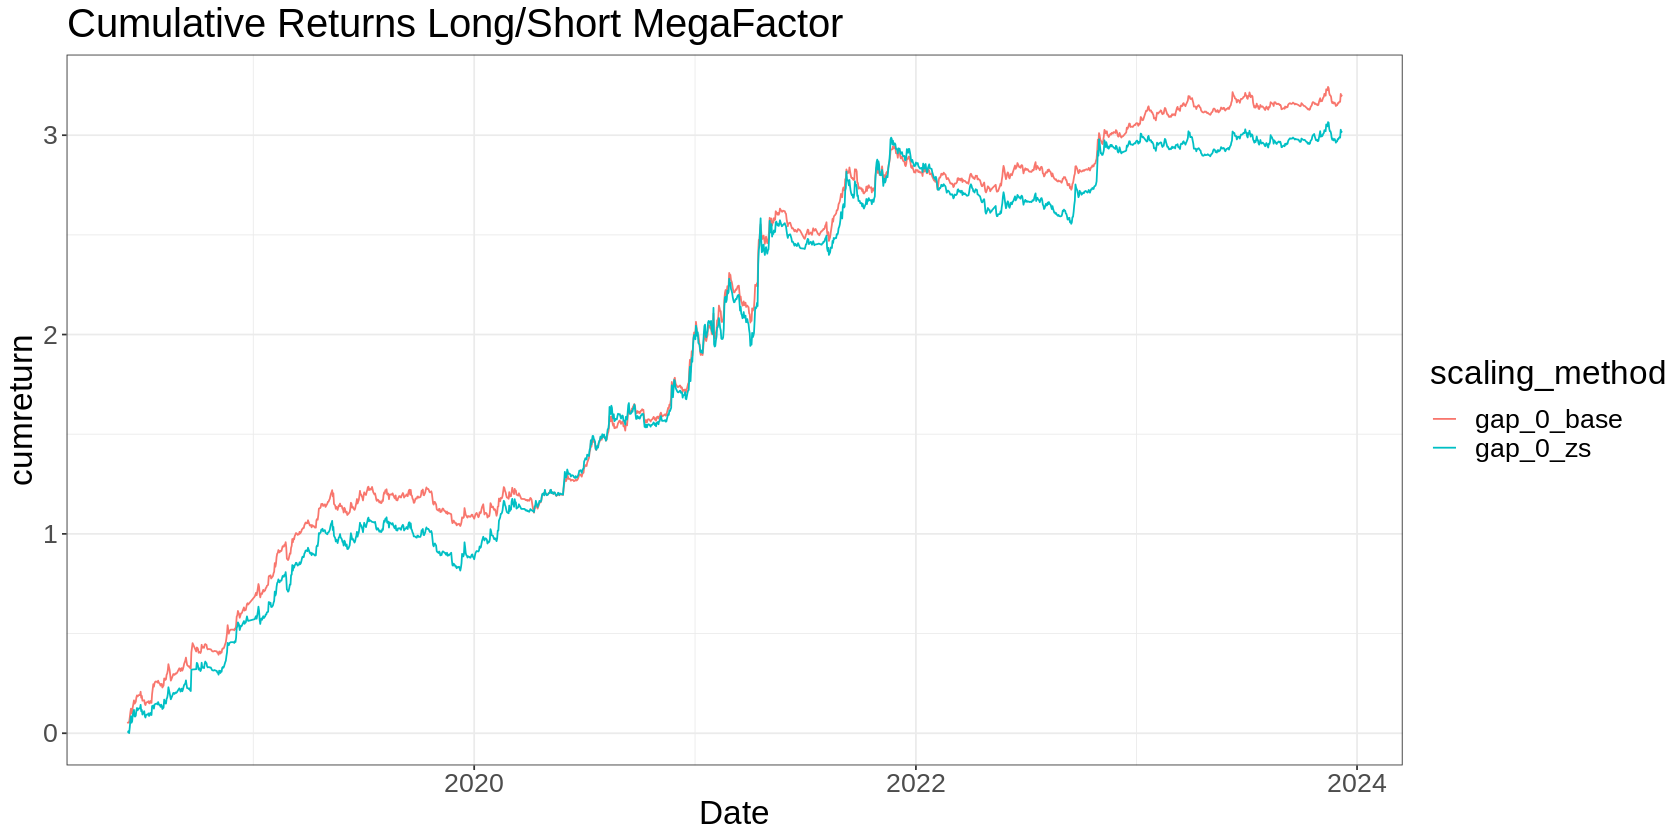

In [10]:
megafactor_cumreturns_scaled_zs %>%
  left_join(megafactor_cumreturns_base, by = "Date", suffix = c("_zs", "_base")) %>%
  pivot_longer(c(starts_with("gap_0")), names_to = "scaling_method", values_to = "cumreturn") %>%
  # pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = scaling_method)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')

Frictionless factor returns are similar, but I would expect an impact on turnover, and therefore after-cost returns.

Let's get the trend factor (which is already basically calculated in this way - features are already scaled by their own historical standard deviation), then we'll run an rsims backtest on the 50/50 combined factors, and compare to our baseline results.

In [11]:
rolling_days_since_high_12 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 12, na_value = NA),
  otherwise = NA
)

rolling_days_since_high_26 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 26, na_value = NA),
  otherwise = NA
)

trend_factor_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Price momo factor
  mutate(
    t_mom_23 = log(Close / lag(Close, n = 23)),
    t_mom_32 = log(Close / lag(Close, n = 32)),
  ) %>%
  # Price to SMA factor
  mutate(
    t_psma_18 = Close / roll_meanr(Close, 18) - 1,
    t_psma_29 = Close / roll_meanr(Close, 29) - 1,
    t_psma_43 = Close / roll_meanr(Close, 43) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    t_smaf_3_13 = roll_meanr(Close, 3) / roll_meanr(Close, 13) - 1,
    t_smaf_3_24 = roll_meanr(Close, 3) / roll_meanr(Close, 24) - 1,
  ) %>%
  # Range over recent history
  mutate(
    t_rrp_8 = (Close - roll_meanr(Close, n = 8)) / roll_sdr(Close, n = 8),
    t_rrp_17 = (Close - roll_meanr(Close, n = 17)) / roll_sdr(Close, n = 17),
    t_rrp_31 = (Close - roll_meanr(Close, n = 31)) / roll_sdr(Close, n = 31),
    t_rrp_38 = (Close - roll_meanr(Close, n = 38)) / roll_sdr(Close, n = 38),
  ) %>%
  # Range
  mutate(
    t_range_10 = (Close - roll_minr(Close, n = 10)) / (roll_maxr(Close, n = 10) - roll_minr(Close, n = 10)) - 0.5,
    t_range_21 = (Close - roll_minr(Close, n = 21)) / (roll_maxr(Close, n = 21) - roll_minr(Close, n = 21)) - 0.5,
    t_range_33 = (Close - roll_minr(Close, n = 33)) / (roll_maxr(Close, n = 33) - roll_minr(Close, n = 33)) - 0.5,
  ) %>%
  # Days since last high factor
  mutate(
    t_dsh_12 = -rolling_days_since_high_10(Close) + 6
  ) %>%
  mutate(
    t_dsh_26 = -rolling_days_since_high_26(Close) + 13
  ) %>%
  # Calculate returns
  mutate(
    fwd_return_1 = lead(Close, 1) / Close - 1,
    fwd_return_2 = lead(Close, 2) / lead(Close, 1) - 1,
    fwd_return_3 = lead(Close, 3) / lead(Close, 2) - 1,
    fwd_log_return_1 = log(lead(Close) / Close),
    fwd_log_return_2 = log(lead(Close, 2) / lead(Close, 1)),
    fwd_log_return_3 = log(lead(Close, 3) / lead(Close, 2))
  ) %>%
  na.omit() %>%
  ungroup()

clamp <- 2.5

trend_ranks <- trend_factor_wide %>%
  pivot_longer(starts_with('t_'), names_to = 'feature', values_to = 'value') %>%
  group_by(Ticker, feature) %>%
  arrange(Date) %>%
  mutate(
    sd_scalemom = value / roll_sdr(value, 60),
    weight = 0.5 * pmax(pmin(sd_scalemom, clamp), -clamp),  # Scale to sit between 1.25 and -1.25
    scaled_weight = 0.1 * weight,                           # 10 assets so divide by 10
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  filter(is_index) %>%
  na.omit() %>%
  ungroup()

trend_factor <- trend_ranks %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  summarise(
    weight = sum(scaled_weight),
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  )

trend_weights <- trend_ranks %>%
  group_by(Date, Ticker) %>%
  summarise(scaled_weight = mean(scaled_weight))

head(trend_weights)

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


Date,Ticker,scaled_weight
<date>,<chr>,<dbl>
2018-05-29,BNB,-0.05730293
2018-05-29,BTC,-0.05800825
2018-05-29,ETH,-0.05670352
2018-05-29,LTC,-0.06073311
2018-05-29,NEO,-0.05543871
2018-05-30,BNB,-0.03602503


## Trend and momentum together

I'll weight the factors 80/20 momentum/trend as in the simulations in notebook 10 for easy comparison.

In [12]:
momo_weight_scale <- 0.8
trend_weight_scale <- 0.2

comboweight <- megafactor_scaled_zs %>%
  inner_join(trend_weights, by = c('Ticker','Date')) %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    momentum_weight = weight/sum(abs(weight))
  ) %>%
  mutate(combo_weight = (momentum_weight * momo_weight_scale) + (trend_weight_scale * scaled_weight))


In [14]:
# get all tickers that were ever in the universe
universe_tickers <- universe %>%
  filter(is_index == TRUE) %>%
  pull(Ticker) %>%
  unique()

print(universe_tickers)

# get start date of simulation (first time we have min constituents)
min_constituents <- 10
start_date <- universe %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  summarise(num_tickers = n()) %>%
  filter(num_tickers >= min_constituents) %>%
  summarise(start_date = first(Date)) %>%
  pull(start_date)

sim_df <- comboweight %>%
  select(Date, Ticker, Close, combo_weight) %>%
  # bind prices on days where our universe tickers weren't in the tradable universe
  # this will assign NA to any combo_weight where the ticker wasn't traded
  bind_rows(
    universe %>%
      filter(Ticker %in% universe_tickers, is_index == FALSE) %>%
      select(Date, Ticker, Close)
  ) %>%
  # assign 0 for any NA combo_weight
  replace_na(list(combo_weight = 0)) %>%
  # sort by date
  arrange(Date, Ticker) %>%
  # remove rows prior to start date
  filter(Date >= start_date)

head(sim_df)

# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- sim_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("combo_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

tail(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- sim_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("Close_")) %>%
  data.matrix()

tail(backtest_prices, c(5, 5))

 [1] "ADA"   "BNB"   "BTC"   "EOS"   "ETH"   "LTC"   "NEO"   "QTUM"  "XRP"  
[10] "XLM"   "ONT"   "TRX"   "ETC"   "BCHSV" "XMR"   "LINK"  "XTZ"   "BCH"  
[19] "DASH"  "DOT"   "DOGE"  "THETA" "FIL"   "UNI"   "ICP"   "SOL"   "AVAX" 
[28] "FLOW"  "SHIB"  "MATIC"


Date,Ticker,Close,combo_weight
<date>,<chr>,<dbl>,<dbl>
2018-06-02,BNB,14.2892,0
2018-06-02,BTC,7662.0300,0
2018-06-02,ETH,595.2700,0
2018-06-02,LTC,123.6900,0
2018-06-02,NEO,56.9000,0
2018-06-03,BNB,14.9692,0


,combo_weight_FIL,combo_weight_DOT,combo_weight_SHIB,combo_weight_ICP,combo_weight_FLOW
"[2008,]",0,0,0,0,0
"[2009,]",0,0,0,0,0
"[2010,]",0,0,0,0,0
"[2011,]",0,0,0,0,0
"[2012,]",0,0,0,0,0


,Close_FIL,Close_DOT,Close_SHIB,Close_ICP,Close_FLOW
"[2008,]",4.809,5.976,9.960e-06,5.113,0.776
"[2009,]",4.876,6.028,9.550e-06,4.891,0.763
"[2010,]",4.973,6.245,9.990e-06,5.046,0.778
"[2011,]",5.310,7.422,1.019e-05,5.375,0.851
"[2012,]",5.085,7.110,1.012e-05,5.410,0.848


Helpers:

In [15]:
# fees - reasonable approximation of actual binance costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.0015,
  2, 0.001,
  3, 0.0008,
  4, 0.0007,
  5, 0.0006,
  6, 0.0004,
  7, 0.0002
)

# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank", trade_on = "close") {
  equity_curve <- backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE))

  fin_eq <- equity_curve %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity_curve %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

## Cost free, no trade buffer

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2018-06-02,1.0000,10000,10000,NA,NA,0
BNB,2018-06-02,14.2892,0,0,0,0,0
BTC,2018-06-02,7662.0300,0,0,0,0,0
ETH,2018-06-02,595.2700,0,0,0,0,0
LTC,2018-06-02,123.6900,0,0,0,0,0
NEO,2018-06-02,56.9000,0,0,0,0,0


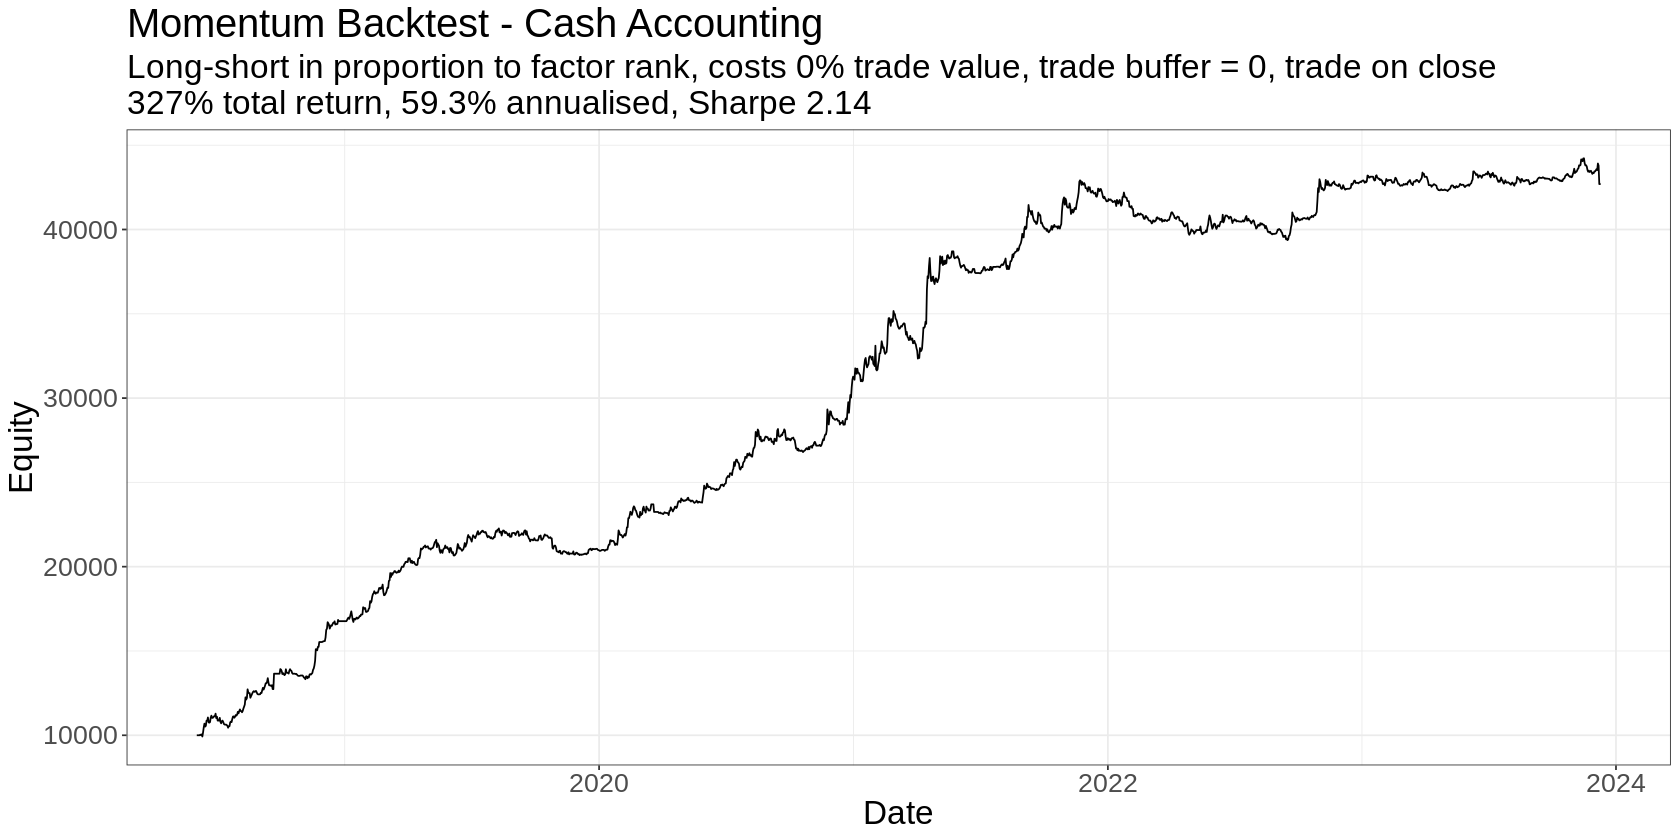

In [16]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

head(results_df)

plot_results(results_df)  # %>% filter(Date >= "2023-10-01"))

This has very similar headline stats to our base case.

Let's see what it looks like with costs but no trade buffer parameter.

## Costs but no trade buffer

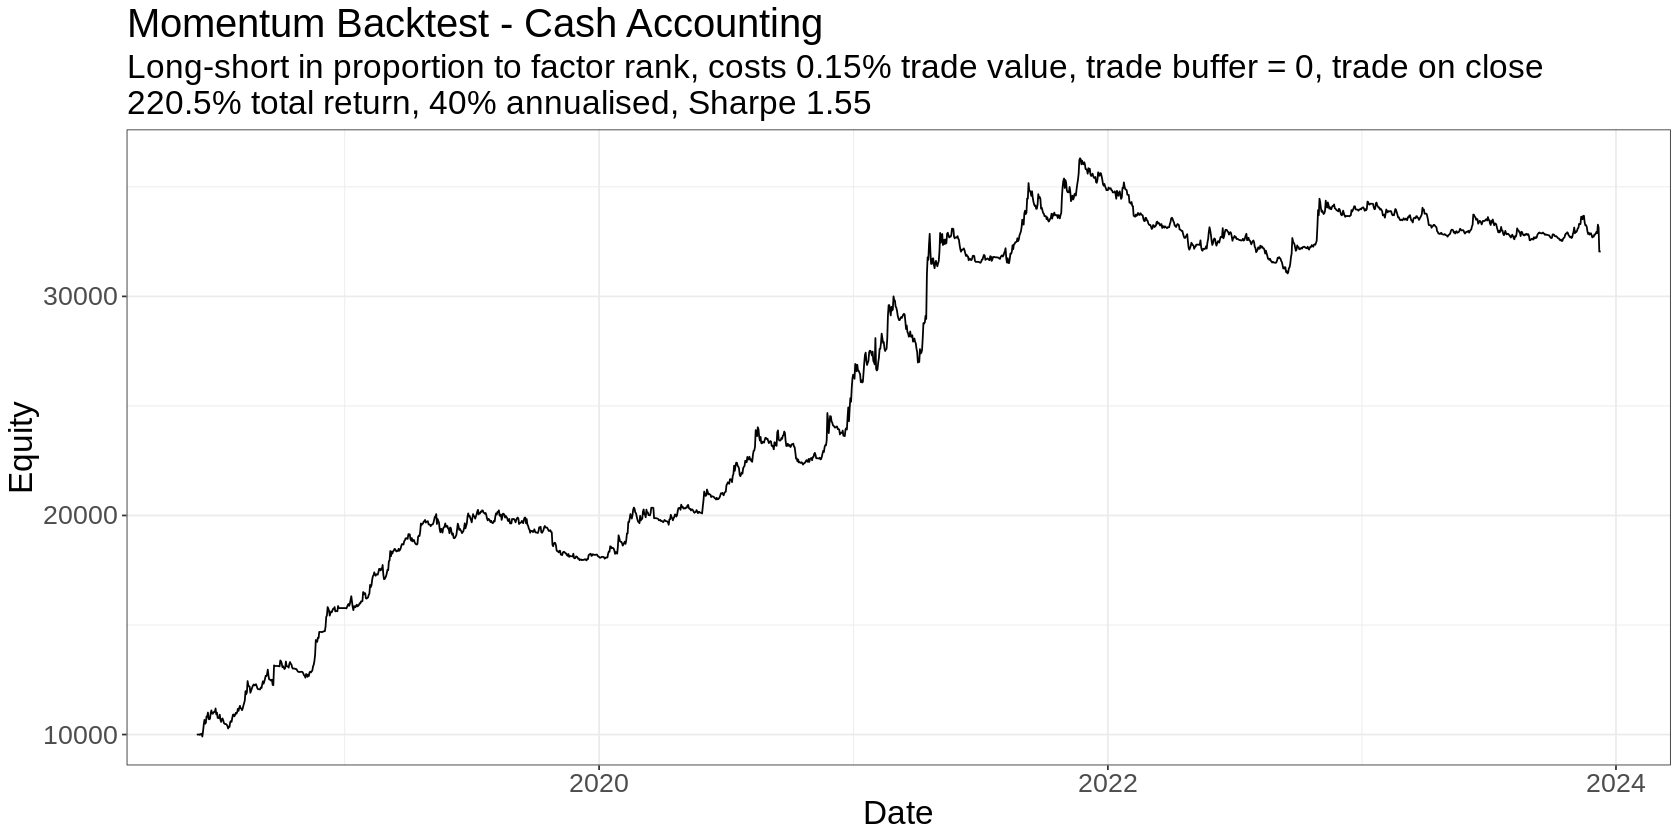

In [17]:
# simulation parameters
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(
  backtest_prices,
  backtest_weights,
  trade_buffer,
  initial_cash,
  commission_pct,
  capitalise_profits
)

results_df %>%
  plot_results()

Similar headline statistics. Let's find our optimal trade buffer:

## Optimal trade buffer

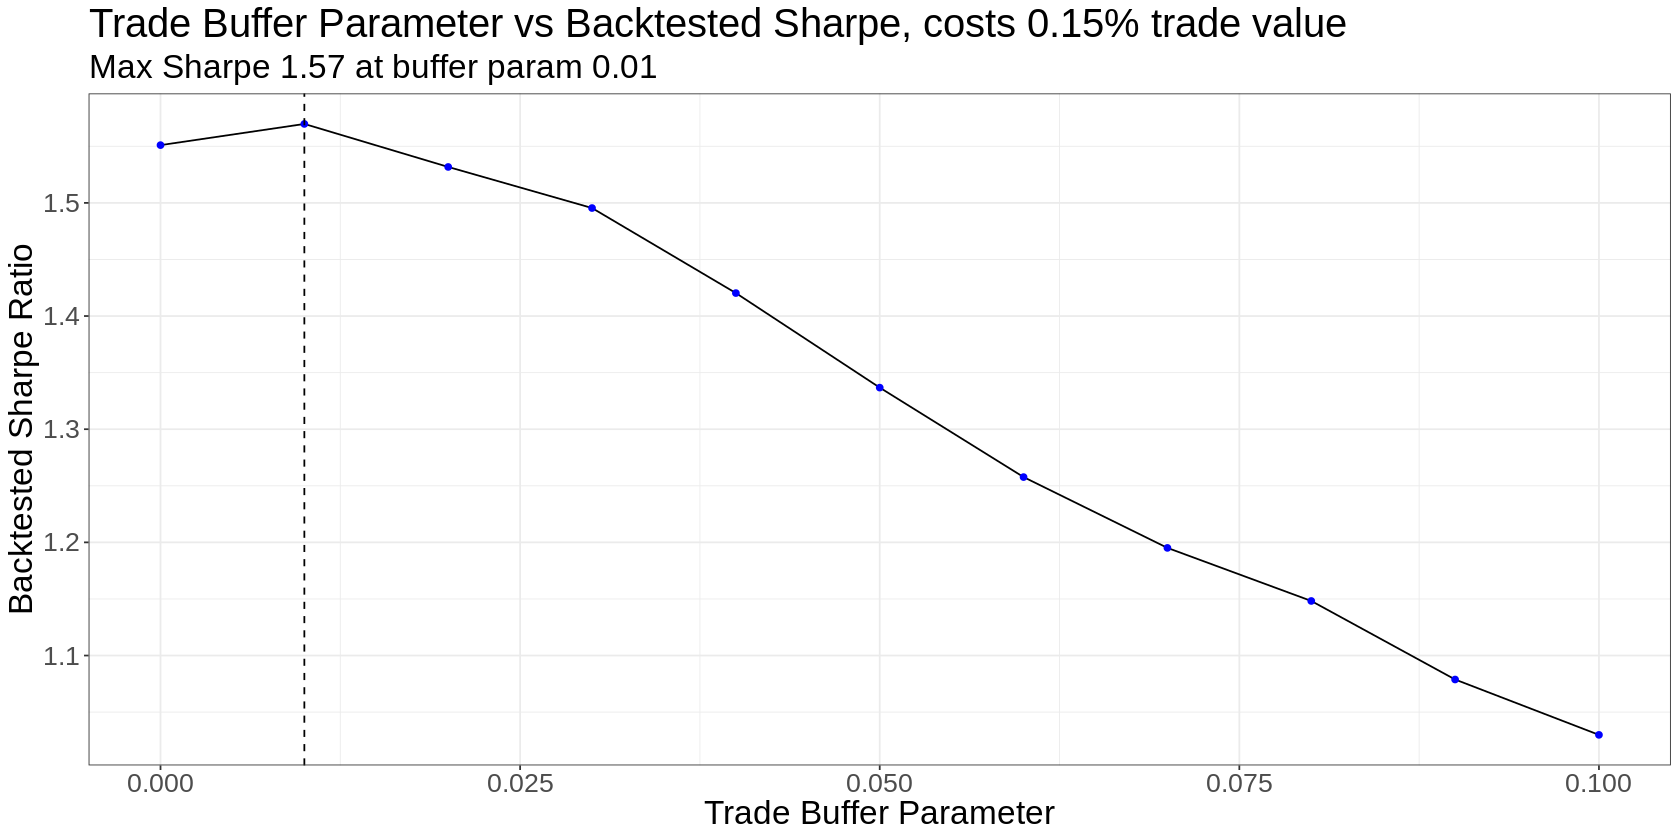

In [18]:
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    cash_backtest(
      backtest_prices,
      backtest_weights,
      trade_buffer,
      initial_cash,
      commission_pct,
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Our optimal trade buffer is 0.01, was 0.02 in the base case.

Let's look at turnover.

## Turnover

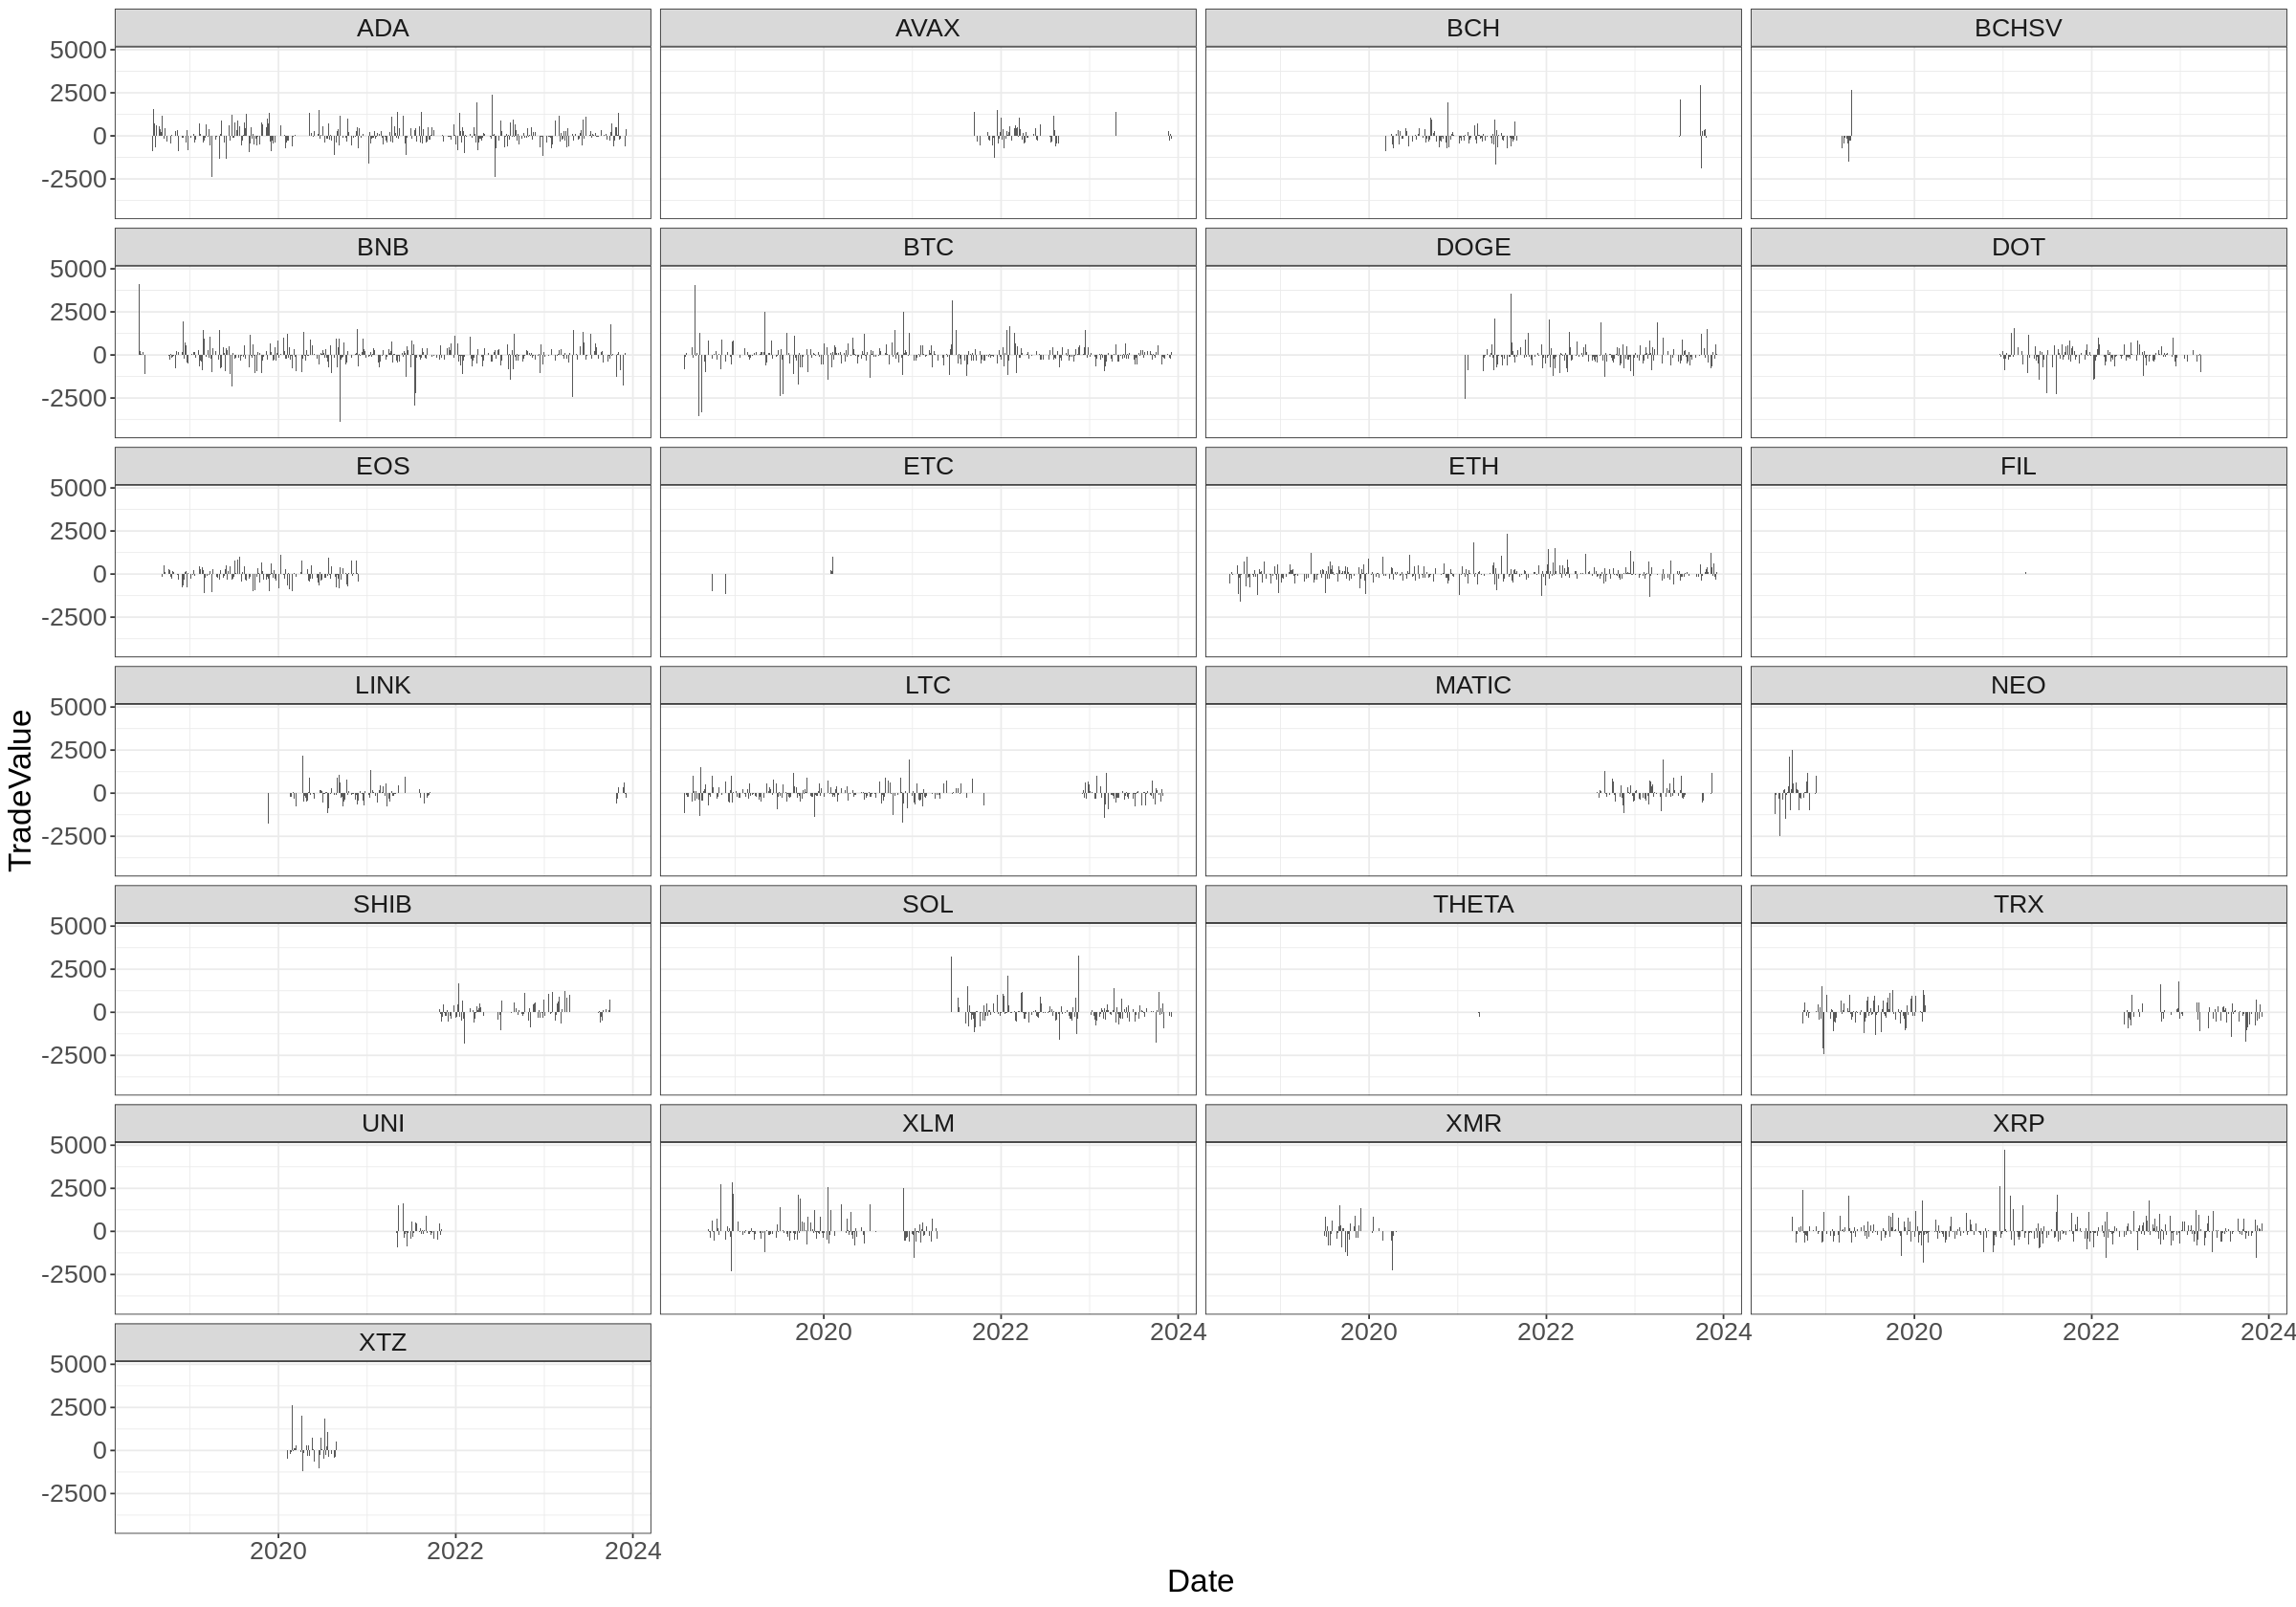

In [19]:
# get back original with costs simulation results
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.01
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

# need a bigger plot
options(repr.plot.width = 20, repr.plot.height=14)

results_df %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 4)

# set back to default
options(repr.plot.width = 14, repr.plot.height=7)

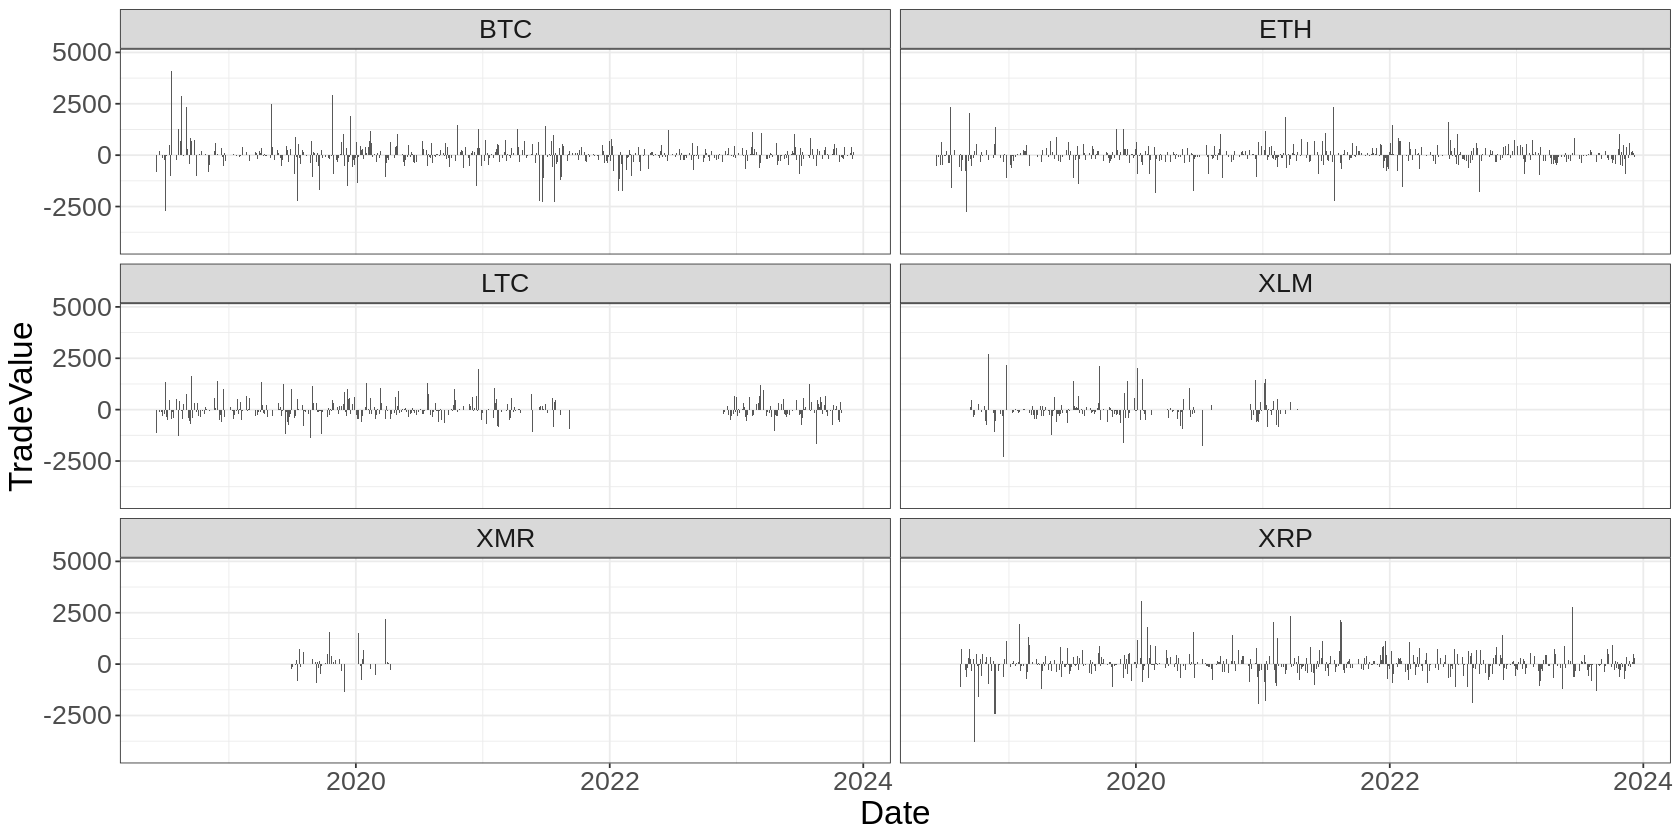

In [20]:
# major coins
results_df %>%
  filter(ticker %in% c("BTC", "ETH", "LTC", "XLM", "XMR", "XRP")) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

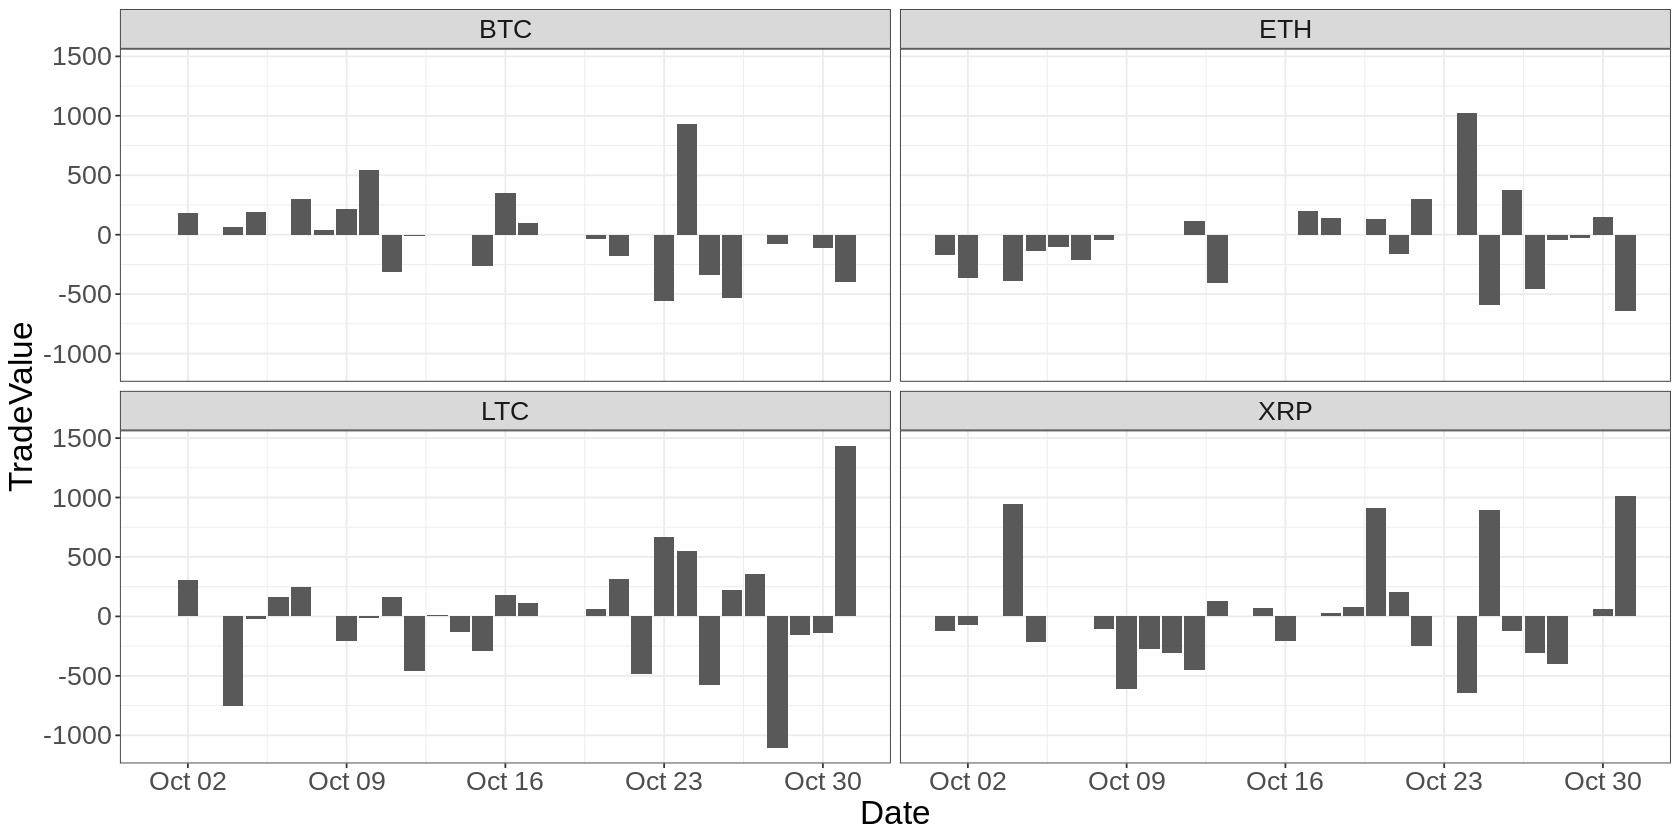

In [21]:
# zoomed in to a recent month
results_df %>%
  filter(
    ticker %in% c("BTC", "ETH", "LTC", "XRP"),
    Date >= "2023-10-01",
    Date < "2023-11-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

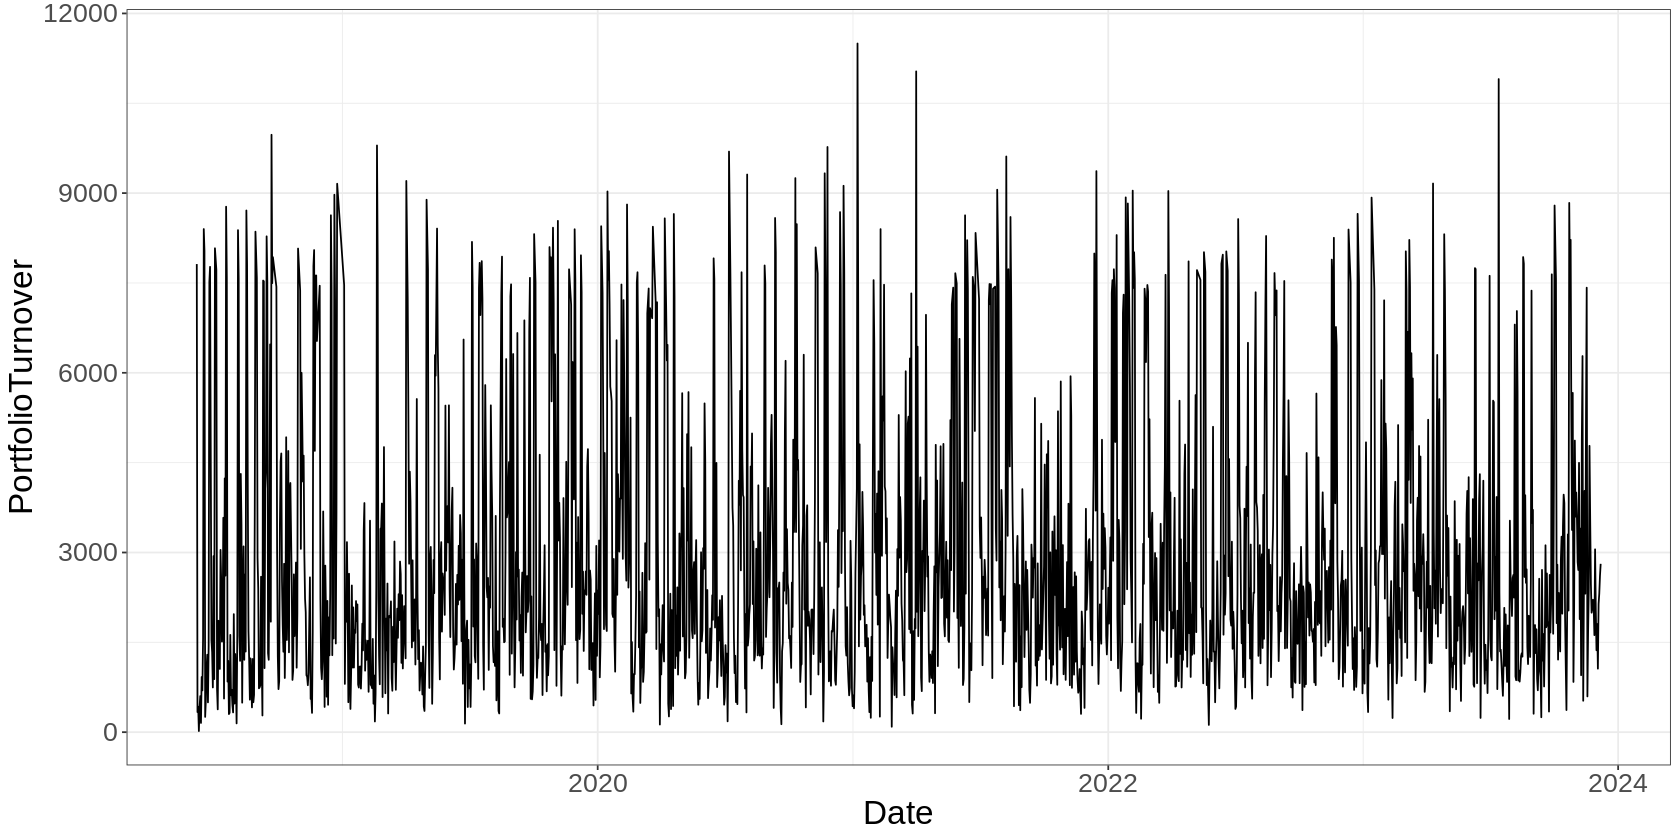

In [22]:
results_df %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  group_by(Date) %>%
  summarise(
    PortfolioTurnover = sum(abs(TradeValue))
  ) %>%
  ggplot(aes(x = Date, y = PortfolioTurnover)) +
  geom_line()

It looks like we've reduced our turnover. In particular, we don't get as many big spikes as previously. Let's quantify this by calculating average daily portfolio turnover


In [23]:
results_df %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  group_by(Date) %>%
  summarise(
    PortfolioTurnover = sum(abs(TradeValue))
  ) %>%
  ungroup() %>%
  summarise(
    MaxPortTurnover = max(PortfolioTurnover),
    AvePortTurnover = mean(PortfolioTurnover),
    MedPortTurnover = median(PortfolioTurnover)
  )

MaxPortTurnover,AvePortTurnover,MedPortTurnover
<dbl>,<dbl>,<dbl>
11497.7,2914.898,2224.375


Interestingly, our average turnover has actually gone up a little, but the the maximum has decreased.

It would be interesting to look at the impact of extending the lookback of the standard deviation on turnover.